[View in Colaboratory](https://colab.research.google.com/github/nakamura41/emotion_detection_notebooks/blob/master/CrowdFlower_Emotion_Analysis_ConvNet.ipynb)

In [1]:
!pip install gensim
!pip install -U -q PyDrive
!pip install -U imbalanced-learn

    100% |████████████████████████████████| 23.5MB 672kB/s 
    100% |████████████████████████████████| 1.4MB 15.3MB/s 
    100% |████████████████████████████████| 133kB 28.0MB/s 
    100% |████████████████████████████████| 61kB 21.7MB/s 
    100% |████████████████████████████████| 4.7MB 747kB/s 
    100% |████████████████████████████████| 552kB 13.1MB/s 
  Running setup.py bdist_wheel for smart-open ... - \ done
  Stored in directory: /root/.cache/pip/wheels/23/00/44/e5b939f7a80c04e32297dbd6d96fa3065af89ecf57e2b5f89f
  Running setup.py bdist_wheel for bz2file ... - done
  Stored in directory: /root/.cache/pip/wheels/81/75/d6/e1317bf09bf1af5a30befc2a007869fa6e1f516b8f7c591cb9
Successfully built smart-open bz2file
    100% |████████████████████████████████| 153kB 13.2MB/s 


In [2]:
import os
import tensorflow as tf
from tensorflow import keras
import numpy as np
import urllib.request
import pandas as pd
from gensim.test.utils import common_texts, get_tmpfile
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec
from tempfile import gettempdir
import zipfile
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE, RandomOverSampler
from collections import Counter

RANDOM_STATE = 41

print(tf.__version__)

Using TensorFlow backend.


1.10.1


In [0]:
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# download google drive file
def download_drive_file(drive_directory, filename):
  list_file_query = "title='{}' and trashed=false".format(drive_directory)
  file_list = drive.ListFile({'q': list_file_query}).GetList()

  if len(file_list) > 0:
    directory_id = file_list[0]['id']

    list_file_query = "'{}' in parents".format(directory_id)

    file_list = drive.ListFile({'q': list_file_query}).GetList()
    
    file_id = None
    for file1 in file_list:
      if file1['title'] == filename:
        print("downloading file {}".format(file1['title']))
        file1.GetContentFile(file1['title'])

In [5]:
download_drive_file("Datasets", "GoogleNews-vectors-negative300.bin.gz")

downloading file GoogleNews-vectors-negative300.bin.gz


In [6]:
!ls

adc.json  GoogleNews-vectors-negative300.bin.gz  sample_data


In [0]:
class CrowdFlowerDataset(object):
  BASE_URL = "https://www.crowdflower.com/wp-content/uploads/2016/07/text_emotion.csv"
  EMOTION_ORIGINAL_CLASSES = ["anger", "boredom", "empty", "enthusiasm", "fun", "happiness", "hate", "love", "neutral", "relief", "sadness", "surprise", "worry"]
  EMOTION_CLASSES = ["anger", "fear", "joy", "love", "neutral", "sadness"]
  EMOTION_CLASSES_DICT = {"anger": 0, "fear": 1, "joy": 2, "love": 3, "neutral": 4, "sadness": 5}
  RANDOM_STATE = 41
  
  # based on Parrott's emotions group
  EMOTION_MAPPING = {
      "anger": "anger",
      "boredom": "sadness",
      "empty": "sadness",
      "enthusiasm": "joy",
      "fun": "joy",
      "happiness": "joy",
      "hate": "anger",
      "love": "love",
      "neutral": "neutral",
      "relief": "joy",
      "sadness": "sadness",
      "surprise": "joy",
      "worry": "fear"
  }
  
  def get_classes(self):
    return self.EMOTION_CLASSES
  
  def get_classes_dict(self):
    return self.EMOTION_CLASSES_DICT
  
  def get_num_classes(self):
    return len(self.EMOTION_CLASSES)

  def __load_data_url(self, url):
    df = pd.read_csv(url)
    df["text"] = df["content"]
    df["emotion"] = df["sentiment"]
    # df = df[df.emotion != "neutral"]
    return df[["text", "emotion"]]
  
  def __emotion_mapping(self, data):
    new_data = data
    for emotion in self.EMOTION_ORIGINAL_CLASSES:
      new_data.loc[data.emotion == emotion, "emotion"] = self.EMOTION_MAPPING[emotion]
    return new_data
    
  def load_data(self):
    train_data = None
    test_data = None
    
    data = self.__load_data_url(self.BASE_URL)
    data = self.__emotion_mapping(data)
    
    train_data, test_data = train_test_split(data, test_size=0.3, random_state=self.RANDOM_STATE, stratify=data["emotion"].values)
    return train_data, test_data

{'anger': 0, 'fear': 1, 'joy': 2, 'love': 3, 'neutral': 4, 'sadness': 5}
['anger', 'fear', 'joy', 'love', 'neutral', 'sadness']


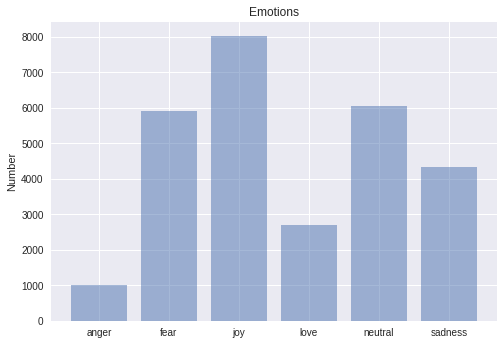

In [8]:
crowd_flower_dataset = CrowdFlowerDataset()
train_data_original, test_data = crowd_flower_dataset.load_data()

emotions = train_data_original.emotion.unique()
dic = crowd_flower_dataset.get_classes_dict()
labels = crowd_flower_dataset.get_classes()
print(dic)
print(labels)

for emotion in labels:
  train_data_original.loc[train_data_original.emotion == emotion, "emotion_int"] = dic[emotion]
  test_data.loc[test_data.emotion == emotion, "emotion_int"] = dic[emotion]
  
num_bins = crowd_flower_dataset.get_num_classes()
bins = [0,1,2,3,4,5,6]
hist, _ = np.histogram(train_data_original["emotion_int"], bins=bins)

objects = crowd_flower_dataset.get_classes()
y_pos = np.arange(len(objects))

plt.bar(y_pos, hist, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Number')
plt.title('Emotions')
 
plt.show()

The training data is very imbalanced!

In [9]:
train_data, val_data = train_test_split(train_data_original, test_size=0.1, random_state=RANDOM_STATE, stratify=train_data_original["emotion"].values)

print('y_train {}'.format(Counter(train_data["emotion"].values)))
print('y_val {}'.format(Counter(val_data["emotion"].values)))
print('y_test {}'.format(Counter(test_data["emotion"].values)))

y_train Counter({'joy': 7218, 'neutral': 5442, 'fear': 5329, 'sadness': 3888, 'love': 2420, 'anger': 903})
y_val Counter({'joy': 802, 'neutral': 605, 'fear': 592, 'sadness': 432, 'love': 269, 'anger': 100})
y_test Counter({'joy': 3437, 'neutral': 2591, 'fear': 2538, 'sadness': 1851, 'love': 1153, 'anger': 430})


### Tokenize training and test dataset

In [22]:
NUM_WORDS=60000
texts = train_data["text"].values
tokenizer = Tokenizer(num_words=NUM_WORDS,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'',
                      lower=True)
tokenizer.fit_on_texts(texts)
sequences_train = tokenizer.texts_to_sequences(texts)
sequences_val = tokenizer.texts_to_sequences(val_data["text"].values)
sequences_test = tokenizer.texts_to_sequences(test_data["text"].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 34805 unique tokens.


In [11]:
X_train_unbalanced = pad_sequences(sequences_train)
X_val = pad_sequences(sequences_val, maxlen=X_train_unbalanced.shape[1])
X_test = pad_sequences(sequences_test, maxlen=X_train_unbalanced.shape[1])

y_train_unbalanced = np.asarray(train_data.emotion.apply(lambda x:dic[x]))
y_val = np.asarray(val_data.emotion.apply(lambda x:dic[x]))
y_test = np.asarray(test_data.emotion.apply(lambda x:dic[x]))

print('Shape of X train, val and test tensor:', X_train_unbalanced.shape, X_val.shape, X_test.shape)
print('Shape of label train, val and test tensor:', y_train_unbalanced.shape, y_val.shape, y_test.shape)

Shape of X train, val and test tensor: (25200, 36) (2800, 36) (12000, 36)
Shape of label train, val and test tensor: (25200,) (2800,) (12000,)


### Balance Training dataset using SMOTE

In [12]:
sm = SMOTE(random_state=RANDOM_STATE)
X_train_smote, y_train_smote = sm.fit_sample(X_train_unbalanced, y_train_unbalanced)

print('Shape of X train tensor which is balanced using SMOTE:', X_train_smote.shape)
print('Original label shape {}'.format(Counter(y_train_unbalanced)))
print('Resampled label shape {}'.format(Counter(y_train_smote)))

Shape of X train tensor which is balanced using SMOTE: (43308, 36)
Original label shape Counter({2: 7218, 4: 5442, 1: 5329, 5: 3888, 3: 2420, 0: 903})
Resampled label shape Counter({2: 7218, 4: 7218, 1: 7218, 0: 7218, 5: 7218, 3: 7218})


### Balance Training dataset using Random Over Sampler

In [13]:
ros = RandomOverSampler(random_state=RANDOM_STATE)
X_train_ros, y_train_ros = ros.fit_sample(X_train_unbalanced, y_train_unbalanced)

print('Shape of X train tensor which is balanced using ROS:', X_train_ros.shape)
print('Original label shape {}'.format(Counter(y_train_unbalanced)))
print('Resampled label shape {}'.format(Counter(y_train_ros)))

Shape of X train tensor which is balanced using ROS: (43308, 36)
Original label shape Counter({2: 7218, 4: 5442, 1: 5329, 5: 3888, 3: 2420, 0: 903})
Resampled label shape Counter({2: 7218, 4: 7218, 1: 7218, 0: 7218, 5: 7218, 3: 7218})


In [0]:
X_train = X_train_ros
y_train = y_train_ros

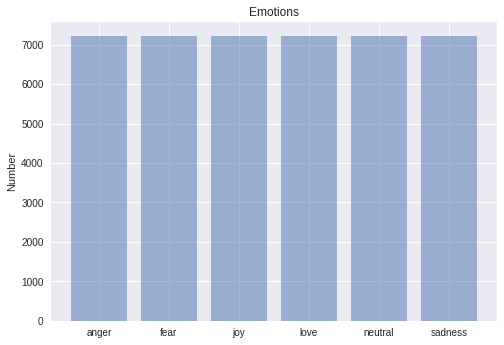

In [15]:
hist, _ = np.histogram(y_train, bins=bins)

y_pos = np.arange(len(objects))

plt.bar(y_pos, hist, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Number')
plt.title('Emotions')
 
plt.show()

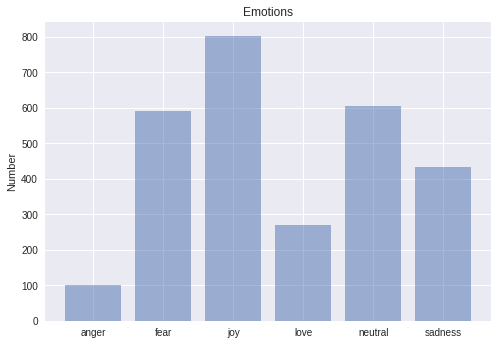

In [16]:
hist, _ = np.histogram(y_val, bins=bins)

y_pos = np.arange(len(objects))

plt.bar(y_pos, hist, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Number')
plt.title('Emotions')
 
plt.show()

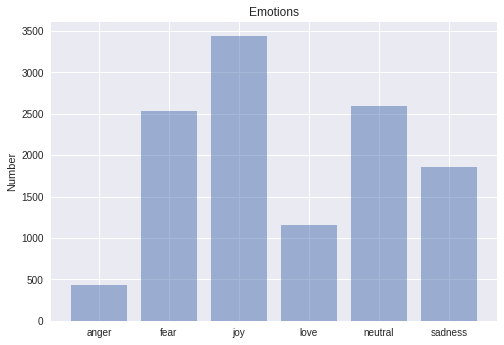

In [17]:
hist, _ = np.histogram(y_test, bins=bins)

y_pos = np.arange(len(objects))

plt.bar(y_pos, hist, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Number')
plt.title('Emotions')
 
plt.show()

In [18]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

print('Shape of X train, validation and test tensor:', X_train.shape, X_val.shape, X_test.shape)
print('Shape of label train, validation and test tensor:', y_train.shape, y_val.shape, y_test.shape)

Shape of X train, validation and test tensor: (43308, 36) (2800, 36) (12000, 36)
Shape of label train, validation and test tensor: (43308, 6) (2800, 6) (12000, 6)


In [0]:
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

from gensim.models.keyedvectors import KeyedVectors

word_vectors = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

In [43]:
EMBEDDING_DIM=300
vocabulary_size = min(len(word_index)+1, NUM_WORDS)
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))

print("vocabulary_size:", vocabulary_size)
print("embedding_matrix shape:", embedding_matrix.shape)

vocabulary_size: 34806
embedding_matrix shape: (34806, 300)


In [0]:
for word, i in word_index.items():
    if i>=NUM_WORDS:
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i] = np.random.normal(0,np.sqrt(0.25), EMBEDDING_DIM)

del(word_vectors)

from keras.layers import Embedding
embedding_layer = Embedding(vocabulary_size,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            trainable=True)

In [45]:
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Conv2D, MaxPooling2D, Dropout, concatenate, LSTM
from keras.layers.core import Reshape, Flatten
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, Adadelta, RMSprop
from keras.models import Model
from keras import regularizers
sequence_length = X_train.shape[1]
filter_sizes = [3,4,5]
num_filters = 100
drop_rate = 0.5
n_class = num_bins

print(sequence_length)

inputs = Input(shape=(sequence_length,), name='input_1')
embedding = embedding_layer(inputs)
reshape = Reshape((sequence_length, EMBEDDING_DIM, 1), name='reshape_1')(embedding)

conv_1 = Conv2D(num_filters, (filter_sizes[0], EMBEDDING_DIM), activation='relu',kernel_regularizer=regularizers.l2(0.01), name='conv_1')(reshape)
conv_2 = Conv2D(num_filters, (filter_sizes[1], EMBEDDING_DIM), activation='relu',kernel_regularizer=regularizers.l2(0.01), name='conv_2')(reshape)
conv_3 = Conv2D(num_filters, (filter_sizes[2], EMBEDDING_DIM), activation='relu',kernel_regularizer=regularizers.l2(0.01), name='conv_3')(reshape)

maxpool_1 = MaxPooling2D((sequence_length - filter_sizes[0] + 1, 1), strides=1, name='maxpool_1')(conv_1)
maxpool_2 = MaxPooling2D((sequence_length - filter_sizes[1] + 1, 1), strides=1, name='maxpool_2')(conv_2)
maxpool_3 = MaxPooling2D((sequence_length - filter_sizes[2] + 1, 1), strides=1, name='maxpool_3')(conv_3)

merged_tensor = concatenate([maxpool_1, maxpool_2, maxpool_3], axis=1, name='concatenate_1')
flatten = Flatten()(merged_tensor)
dropout = Dropout(drop_rate, name='dropout_1')(flatten)
output = Dense(units=n_class, activation='softmax',kernel_regularizer=regularizers.l2(0.01), name='dense_1')(dropout)

# this creates a model that includes
model = Model(inputs, output)

model.summary()

36
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 36)           0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 36, 300)      10441800    input_1[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 36, 300, 1)   0           embedding_3[0][0]                
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 34, 1, 100)   90100       reshape_1[0][0]                  
__________________________________________________________________________________________________
conv_2 

In [46]:
adam = Adam(lr=1e-3, decay=0.0)
adadelta = Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)
rmsprop = RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)

model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['acc'])
callbacks = [EarlyStopping(monitor='val_loss', patience=5)]
history = model.fit(X_train, y_train, batch_size=1000, epochs=100, verbose=1, validation_data=(X_val, y_val), callbacks=callbacks)  # starts training

Train on 43308 samples, validate on 2800 samples
Epoch 1/100
43308/43308 [==============================] - 9s 217us/step - loss: 1.8166 - acc: 0.3368 - val_loss: 1.7785 - val_acc: 0.3621
Epoch 2/100
43308/43308 [==============================] - 6s 136us/step - loss: 1.6004 - acc: 0.4680 - val_loss: 1.7154 - val_acc: 0.3725
Epoch 3/100
43308/43308 [==============================] - 6s 137us/step - loss: 1.4935 - acc: 0.5151 - val_loss: 1.7002 - val_acc: 0.3857
Epoch 4/100
43308/43308 [==============================] - 6s 136us/step - loss: 1.4220 - acc: 0.5438 - val_loss: 1.7110 - val_acc: 0.3982
Epoch 5/100
43308/43308 [==============================] - 6s 137us/step - loss: 1.3619 - acc: 0.5754 - val_loss: 1.7261 - val_acc: 0.3850
Epoch 6/100
43308/43308 [==============================] - 6s 136us/step - loss: 1.3110 - acc: 0.6078 - val_loss: 1.7319 - val_acc: 0.3900
Epoch 7/100
43308/43308 [==============================] - 6s 136us/step - loss: 1.2633 - acc: 0.6325 - val_loss: 1.7

In [0]:
sequences_test=tokenizer.texts_to_sequences(test_data.text)
X_test = pad_sequences(sequences_test, maxlen=X_test.shape[1])
y_pred = model.predict(X_test)

In [48]:
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [0]:
y_pred_original = [labels[val] for val in np.argmax(y_pred, axis=1).squeeze()]
y_test_original = np.asarray(test_data.emotion)

In [0]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (4,3), fontsize=15):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

In [51]:
cf_matrix = confusion_matrix(y_test_original, y_pred_original, labels=labels)

df_cm = pd.DataFrame(
    cf_matrix, index=labels, columns=labels, 
)

df_cm

,anger,fear,joy,love,neutral,sadness
anger,171,72,36,8,61,82
fear,217,688,379,137,524,593
joy,115,358,1356,545,803,260
love,25,49,305,590,115,69
neutral,128,381,466,202,1174,240
sadness,184,409,223,90,329,616


Figure(288x216)


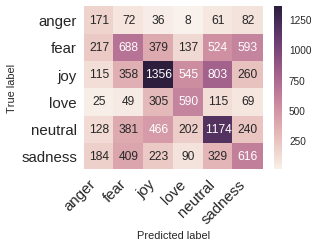

In [52]:
print(print_confusion_matrix(cf_matrix, class_names=labels))

In [53]:
test_accuracy = accuracy_score(y_test_original, y_pred_original)
print("test accuracy:", test_accuracy)

test accuracy: 0.3829166666666667


### Performance score for each classes

In [54]:
precision, recall, fscore, support = precision_recall_fscore_support(y_test_original, y_pred_original)
score_dict = {
  "precision": precision.round(4),
  "recall": recall.round(4),
  "f1-score": fscore.round(4),
  "support": support.round(4)
}
score_df = pd.DataFrame(score_dict, index=labels)
score_df

,f1-score,precision,recall,support
anger,0.2693,0.2036,0.3977,430
fear,0.3061,0.3516,0.2711,2538
joy,0.4373,0.4904,0.3945,3437
love,0.4330,0.3753,0.5117,1153
neutral,0.4195,0.3906,0.4531,2591
sadness,0.3320,0.3312,0.3328,1851


### Performance score using micro average

In [55]:
precision, recall, fscore, support = precision_recall_fscore_support(y_test_original, y_pred_original, average="micro")
score_dict = {
  "precision": precision.round(4),
  "recall": recall.round(4),
  "f1-score": fscore.round(4),
  "support": support
}
score_df = pd.DataFrame(score_dict, index=["score"])
score_df

,f1-score,precision,recall,support
score,0.3829,0.3829,0.3829,None


### Performance score using macro average

In [56]:
precision, recall, fscore, support = precision_recall_fscore_support(y_test_original, y_pred_original, average="macro")
score_dict = {
  "precision": precision.round(4),
  "recall": recall.round(4),
  "f1-score": fscore.round(4),
  "support": support
}
score_df = pd.DataFrame(score_dict, index=["score"])
score_df

,f1-score,precision,recall,support
score,0.3662,0.3571,0.3935,None


### Performance score using weighted average

In [57]:
precision, recall, fscore, support = precision_recall_fscore_support(y_test_original, y_pred_original, average="weighted")
score_dict = {
  "precision": precision.round(4),
  "recall": recall.round(4),
  "f1-score": fscore.round(4),
  "support": support
}
score_df = pd.DataFrame(score_dict, index=["score"])
score_df

,f1-score,precision,recall,support
score,0.383,0.3936,0.3829,None
